In [ ]:
# This Notebook is for experimenting with features & trying to improve boosting models
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer, cohen_kappa_score, accuracy_score

pd.set_option('display.max_columns', None)
import joblib
import optuna
import torch


In [ ]:
# TODO: forward selection: use only features that improves kappa
def featurize_table(data_df):
    tabular_df = data_df.copy()
    # Namelength
    tabular_df["name_length"] = tabular_df['Name'].str.len().fillna(0)
    
    # Description length
    tabular_df['description_length'] = tabular_df['Description'].str.len().fillna(0)
    
    # Is Mixed Breed? (Breed2 is not 0)
    tabular_df['is_mixed_breed'] = (tabular_df['Breed2'] != 0).astype(int)
    
    
    
    # 1. Text
    tabular_df['word_count'] = tabular_df['Description'].str.split().str.len().fillna(0)
    tabular_df['char_count'] = tabular_df['Description'].str.len().fillna(0)
    tabular_df['avg_word_len'] = tabular_df['char_count'] / (tabular_df['word_count'] + 1)
    tabular_df['num_digits'] = tabular_df['Description'].apply(lambda x: sum(c.isdigit() for c in str(x)))
    tabular_df['all_caps_ratio'] = tabular_df['Description'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / max(1, len(str(x))))

    # 2. Measures
    tabular_df['fee_per_pet'] = tabular_df['Fee'] / tabular_df['Quantity'].replace(0,1)
    tabular_df['photo_per_pet'] = tabular_df['PhotoAmt'] / tabular_df['Quantity']
    tabular_df['age_per_size'] = tabular_df['Age'] / tabular_df['MaturitySize'] # Needs careful handling of 0s
    tabular_df['total_media'] = tabular_df['PhotoAmt'] + tabular_df['VideoAmt'] # Total Media (Engagement proxy)
    tabular_df['num_colors'] = (tabular_df[['Color1', 'Color2', 'Color3']] != 0).sum(axis=1) # Number of Colors (Count non-zero color columns)
    
    
    # 3. Simple Interactions
    tabular_df['is_mixed_breed'] = (tabular_df['Breed2'] != 0) & (tabular_df['Breed2'].notnull())
    tabular_df['is_specific_color'] = (tabular_df['Color2'] != 0) # Has more than 1 color    
    tabular_df['is_free'] = (tabular_df['Fee'] == 0).astype(int)    # Is Free? (Fee is 0)
    tabular_df['has_health_issue'] = (tabular_df['Health'] > 1).astype(int)   # Health Issue Flag (Health > 1 implies injury or condition)
    
    # log transform for shit and giggles
    tabular_df['Fee'] = np.log1p(tabular_df['Fee'])
    tabular_df['PhotoAmt'] = np.log1p(tabular_df['PhotoAmt'])
    
    # Check whether this
     
    # Drop useless features -> does this actually works?
    features_to_drop = [""]
    
    # Encode categories
    cat_cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 
                    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
                    'Sterilized', 'Health', 'State']
    for col in cat_cols:
        if col in tabular_df.columns:
            tabular_df[col] = tabular_df[col].astype('category')
        

    tabular_df.drop(['Name', 'PetID', 'Description', "RescuerID", 'Color2', 'is_free', 'Vaccinated', 'num_colors', 'name_length'], axis=1, inplace=True)
    return tabular_df


In [13]:
# Advanced Features
def extract_sentiment_from_json(pet_id, sentiment_dir="../data/train_sentiment/"):
    # This assumes the sentiment files follow the pattern {PetID}.json
    filename = f"{sentiment_dir}/{pet_id}.json"
    try:
        if os.path.exists(filename):
            with open(filename, 'r') as f:
                data = json.load(f)
            # Usually 'documentSentiment' holds the overall score
            if 'documentSentiment' in data:
                return data['documentSentiment']['score'], data['documentSentiment']['magnitude']
    except:
        pass
    return 0, 0 # Default if missing


def generate_text_features(df, svd_components=20, is_train=True, fit_on_text=None):
    """
    df: The dataframe (containing 'Description' and 'PetID')
    svd_components: Number of latent features to keep
    is_train: Boolean, used to decide whether to fit or transform
    fit_on_text: If is_train=False, pass the vectorizers here (tuple: tfidf, svd)
    """
    df_text = df.copy()
    
    # 1. TF-IDF + SVD (Latent Semantic Analysis)
    print("Generating TF-IDF SVD features...")
    descriptions = df_text['Description'].fillna("none").astype(str)
    
    if is_train:
        # Fit on TRAINING descriptions
        tfidf = TfidfVectorizer(min_df=3,  max_features=1000, 
                                strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
                                ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True,
                                stop_words = 'english')
        
        svd = TruncatedSVD(n_components=svd_components, random_state=42)
        
        # Fit Transform
        tf_vecs = tfidf.fit_transform(descriptions)
        svd_vecs = svd.fit_transform(tf_vecs)
        
        # Save vectorizers for inference later
        vectorizers = (tfidf, svd)
    else:
        # Load from passed tuple
        tfidf, svd = fit_on_text
        tf_vecs = tfidf.transform(descriptions)
        svd_vecs = svd.transform(tf_vecs)
        vectorizers = fit_on_text

    # Create Columns
    svd_df = pd.DataFrame(svd_vecs, columns=[f'svd_desc_{i}' for i in range(svd_components)])
    # We reset index to make sure concat aligns correctly row-by-row
    df_text = pd.concat([df_text.reset_index(drop=True), svd_df], axis=1)

    # 2. Sentiment Analysis (File-based lookup)
    # Determine directory
    sent_dir = "../data/train_sentiment" if is_train else "../data/test_sentiment"
    
    print("Extracting Sentiment...")
    # Apply row-wise (can be slow, maybe parallelize with pandarallel if needed)
    sent_data = df_text['PetID'].apply(lambda x: extract_sentiment_from_json(x, sent_dir))
    
    df_text['sentiment_score'] = [x[0] for x in sent_data]
    df_text['sentiment_magnitude'] = [x[1] for x in sent_data]
    df_text['sentiment_polarity'] = df_text['sentiment_score'] * df_text['sentiment_magnitude']

    return df_text, vectorizers

In [14]:
# Load Data
full_df = pd.read_csv("../data/train/train.csv") #Beware of directory

# Splitting the data from train.csv
X = full_df.drop(['AdoptionSpeed'], axis=1)
y = full_df['AdoptionSpeed'] 
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Generate  Features
X_train_text, vec_tuple = generate_text_features(X_train_raw, is_train=True)
X_test_text, _ = generate_text_features(X_test_raw,is_train=False, fit_on_text=vec_tuple)


X_train = featurize_table(X_train_text)
X_test = featurize_table(X_test_text)
X_train

Generating TF-IDF SVD features...
Extracting Sentiment...
Generating TF-IDF SVD features...
Extracting Sentiment...


,Type,Age,Breed1,Breed2,Gender,Color1,Color3,MaturitySize,FurLength,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,svd_desc_0,svd_desc_1,svd_desc_2,svd_desc_3,svd_desc_4,svd_desc_5,svd_desc_6,svd_desc_7,svd_desc_8,svd_desc_9,svd_desc_10,svd_desc_11,svd_desc_12,svd_desc_13,svd_desc_14,svd_desc_15,svd_desc_16,svd_desc_17,svd_desc_18,svd_desc_19,sentiment_score,sentiment_magnitude,sentiment_polarity,description_length,is_mixed_breed,word_count,char_count,avg_word_len,num_digits,all_caps_ratio,fee_per_pet,photo_per_pet,age_per_size,total_media,is_specific_color,has_health_issue
0,1,2,307,307,1,1,0,2,2,1,2,1,3,0.0,41326,0,2.197225,0.244532,-0.037060,0.008682,0.020883,0.126230,0.017125,0.043185,0.036605,0.047601,-0.051458,-0.064420,0.069778,-0.011776,-0.090580,-0.023213,-0.160635,-0.080065,0.086479,-0.009234,0.052999,0,0,0,450.0,True,80.0,450.0,5.555556,4,0.008889,0.0,2.666667,1.0,8.0,False,0
1,1,12,307,0,2,2,0,1,1,1,1,1,1,0.0,41326,0,1.386294,0.129967,-0.014390,-0.011191,0.214028,-0.024347,0.093595,-0.125752,0.019212,-0.016720,0.074427,0.200051,0.089453,0.019649,-0.018445,-0.122734,-0.038898,-0.004980,-0.025647,-0.053705,-0.021235,0,0,0,77.0,False,12.0,77.0,5.923077,0,0.038961,0.0,3.000000,12.0,3.0,False,0
2,1,2,307,307,1,1,7,2,1,2,2,1,1,0.0,41326,0,0.693147,0.036105,0.006319,0.009052,-0.040065,0.043863,0.006899,-0.002840,0.006765,0.023516,-0.024033,0.026478,0.035405,-0.059616,-0.016858,-0.010160,-0.060419,0.012564,0.026524,-0.009877,0.079327,0,0,0,29.0,True,5.0,29.0,4.833333,0,0.137931,0.0,1.000000,1.0,1.0,True,0
3,1,2,307,307,1,3,0,2,2,1,2,1,1,0.0,41326,0,1.098612,0.230322,0.946186,0.060190,0.014545,-0.101189,-0.003106,0.061647,0.002062,0.002932,-0.037770,0.000950,-0.022837,0.026151,0.017754,0.032926,0.068430,-0.074480,-0.007891,0.010836,0.008565,0,0,0,12.0,True,2.0,12.0,4.000000,0,0.083333,0.0,2.000000,1.0,2.0,False,0
4,2,4,265,0,3,1,0,2,2,2,2,1,4,0.0,41326,0,1.098612,0.136872,0.353950,-0.019017,-0.113207,-0.015904,-0.024246,0.053143,-0.041385,0.047071,0.111267,-0.043739,0.015210,0.024690,-0.049469,-0.065180,-0.037186,-0.137048,-0.122686,0.068733,-0.073205,0,0,0,20.0,False,3.0,20.0,5.000000,0,0.050000,0.0,0.500000,2.0,2.0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11989,2,8,265,299,2,1,0,2,2,1,2,1,1,0.0,41326,0,1.098612,0.205444,-0.049414,-0.057199,0.036065,0.039162,0.026868,0.063012,-0.002587,-0.046638,-0.040758,0.061714,-0.104008,0.038616,-0.016623,0.024413,-0.001041,0.036241,-0.085281,-0.118394,-0.003344,0,0,0,340.0,True,66.0,340.0,5.074627,1,0.014706,0.0,2.000000,4.0,2.0,True,0
11990,1,2,307,0,2,6,0,1,1,1,3,1,1,0.0,41326,0,0.693147,0.224184,-0.049292,0.025368,0.003476,0.110897,0.027647,0.018800,-0.007240,0.129459,-0.085259,-0.065398,0.126936,-0.033020,0.036416,0.069005,0.006937,0.017209,-0.002086,-0.028476,-0.054225,0,0,0,313.0,False,63.0,313.0,4.890625,1,0.015974,0.0,1.000000,2.0,1.0,True,0
11991,1,2,307,307,1,1,0,2,2,1,2,1,1,0.0,41401,0,1.098612,0.161576,-0.049235,0.056162,0.033361,-0.003143,-0.019945,0.108630,0.023962,0.007483,-0.087941,-0.011080,-0.015146,0.019132,-0.032981,-0.071715,-0.088255,0.021091,0.036146,0.006831,0.019530,0,0,0,284.0,True,50.0,284.0,5.568627,0,0.021127,0.0,2.000000,1.0,2.0,False,0
11992,1,2,307,307,1,1,7,2,2,2,2,1,1,0.0,41326,0,1.098612,0.163324,-0.050198,-0.018858,0.013617,0.006744,-0.046310,0.054158,-0.027762,0.085841,0.020232,-0.038258,-0.070167,0.044753,-0.022347,-0.082730,0.003721,-0.048951,-0.022561,0.039550,0.035044,0,0,0,219.0,True,42.0,219.0,5.093023,0,0.027397,0.0,2.000000,1.0,2.0,True,0


In [15]:
# Plan 1: normal classification
# Hyperparameter-tuning w/Optuna

# Calculate weights inversely proportional to class frequencies
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
def objective(trial):
    params = {
        # Config for how to predict
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 5,
        'tree_method': 'hist', # Faster training
        'enable_categorical': True,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # % of feature used per tree
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set (futher split from train set)
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, 
                                                stratify=y_train
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBClassifier(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    kappa = cohen_kappa_score(y_val, preds, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = 5

xgb_optuna = xgb.XGBClassifier(**best_params)
xgb_optuna.fit(X_train, y_train, sample_weight=sample_weights) 
pred_xgb = xgb_optuna.predict(X_test)
#joblib.dump(xgb_optuna, 'xgb_optuna_full.pkl')

Best trial value: 0.39966817154982404
Best params: {'n_estimators': 333, 'learning_rate': 0.02661615982777823, 'max_depth': 10, 'subsample': 0.7437509519190323, 'colsample_bytree': 0.9046030628769993, 'min_child_weight': 2, 'reg_alpha': 2.1844789979424597, 'reg_lambda': 5.575152748199827}


In [16]:
# Plan 2: reg with optimized rounder
# Hyperparameter-tuning w/Optuna (Regressor)
import optuna
# Spaghetti split 
X_train_model, X_val_rounder, y_train_model, y_val_rounder = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        #'num_class': 5,
        'tree_method': 'hist', # Faster training
        'device': 'cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
        # Tuning parameters
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000), # More trees, but early stopping handles it
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    # Split for early stopping (Optuna needs a validation set)
    # Using specific validation set
    X_tr, X_val, y_tr, y_val = train_test_split(X_train_model, y_train_model, test_size=0.1, random_state=42, 
                                                stratify=y_train_model
                                                )

    # Choose regressor if trying to use with optimied rounder
    model = xgb.XGBRegressor(**params, early_stopping_rounds=50)
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # FIXED: Round continuous predictions to integers for Kappa calculation
    preds = model.predict(X_val)
    preds_rounded = np.rint(preds).astype(int).clip(0, 4) 
    kappa = cohen_kappa_score(y_val, preds_rounded, weights='quadratic')
    return kappa

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 smart trials

print(f"Best trial value: {study.best_value}")
print(f"Best params: {study.best_params}")

# Use best params
best_params = study.best_params
# Add fixed params back
best_params['objective'] = 'reg:squarederror'

xgb_optuna_reg = xgb.XGBRegressor(**best_params)
xgb_optuna_reg.fit(X_train_model, y_train_model) 
pred_xgb_reg_raw = xgb_optuna_reg.predict(X_test)
pred_xgb_reg = np.rint(pred_xgb_reg_raw).astype(int).clip(0, 4)
#joblib.dump(xgb_optuna_reg, 'xgb_optuna_reg_full.pkl')

Best trial value: 0.3486310112270351
Best params: {'n_estimators': 537, 'learning_rate': 0.020123574576396578, 'max_depth': 12, 'subsample': 0.862149565494488, 'colsample_bytree': 0.680164080507201, 'min_child_weight': 5, 'reg_alpha': 1.3054917166483393, 'reg_lambda': 3.1675466785451816}


In [31]:
from catboost import CatBoostClassifier, Pool

# Define categorical features indices
cat_feature_names = list(X_train.select_dtypes(include=['category']).columns)
print(f"Categorical features for CatBoost: {cat_feature_names}")

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, 
                                                stratify=y_train
                                                )

# CatBoost handles the categories automatically (no need for OHE)
clf = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    eval_metric='Kappa',
    loss_function='MultiClass',
    cat_features=cat_feature_names,
    verbose=100
)

clf.fit(X_tr, y_tr, eval_set=(X_val, y_val))

pred_cat = clf.predict(X_test)

Categorical features for CatBoost: ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color3', 'MaturitySize', 'FurLength', 'Dewormed', 'Sterilized', 'Health', 'State']
0:	learn: 0.0952128	test: 0.1040142	best: 0.1040142 (0)	total: 49.6ms	remaining: 49.5s
100:	learn: 0.2416129	test: 0.1962177	best: 0.1973963 (99)	total: 5.86s	remaining: 52.2s
200:	learn: 0.3076518	test: 0.2045463	best: 0.2066622 (197)	total: 12s	remaining: 47.6s
300:	learn: 0.3810962	test: 0.2087423	best: 0.2132675 (294)	total: 17.9s	remaining: 41.6s
400:	learn: 0.4335195	test: 0.2165673	best: 0.2192375 (390)	total: 23.8s	remaining: 35.6s
500:	learn: 0.4802033	test: 0.2138293	best: 0.2205544 (405)	total: 29.9s	remaining: 29.8s
600:	learn: 0.5225757	test: 0.2174048	best: 0.2205544 (405)	total: 36.2s	remaining: 24s
700:	learn: 0.5575712	test: 0.2211213	best: 0.2211248 (698)	total: 42.4s	remaining: 18.1s
800:	learn: 0.5962520	test: 0.2233705	best: 0.2233705 (800)	total: 48.6s	remaining: 12.1s
900:	learn: 0.6233392	test: 0.

In [17]:
# Rounder for regressor -> final label
# TODO: this creates leak?!
from oprounder import OptimizedRounder

# for fitting the rounder
#pred_train_reg = xgb_optuna_reg.predict(X_train)
pred_val_rounder = xgb_optuna_reg.predict(X_val_rounder) 

# what we want to predict (eval)
pred_test_reg = xgb_optuna_reg.predict(X_test)

# Fit the Optimized Rounder on Training Data
rounder = OptimizedRounder(n_classes=y_train.nunique(), n_trials=100)
rounder.fit(pred_val_rounder, y_val_rounder) 


# View the learned thresholds
print(f'Optimal thresholds: {rounder.thresholds}')

# Predict on Test Data using the new thresholds
pred_reg_optimized = rounder.predict(pred_test_reg) # use the new threshold to pick label

# Compare how the new threshold improve kappa
kappa = cohen_kappa_score(y_test, pred_reg_optimized, weights='quadratic')
print(f'Optimal Quadratic kappa: {kappa:.4f}')

kappa = cohen_kappa_score(y_test, pred_xgb_reg, weights='quadratic')
print(f'Original Quadratic kappa: {kappa:.4f}')

Optimal thresholds: [1.7061797991863976, 2.1605343922581506, 2.615180337254572, 3.0358200573795293]
Optimal Quadratic kappa: 0.4031
Original Quadratic kappa: 0.3000


In [ ]:
# Save the models
#joblib.dump(xgb_optuna, 'xgb_optuna.pkl')
#joblib.dump(xgb_optuna_reg, 'xgb_optuna_reg.pkl')

['xgb_optuna_reg.pkl']

# Evaluate

In [32]:
from sklearn.metrics import cohen_kappa_score, accuracy_score

def evaluate_model(model, model_prediction):
    print(f"Model: {model.__class__.__name__}")
    print(f"Kappa Score: {cohen_kappa_score(model_prediction, y_test, weights='quadratic'):.4f}")
    print(f"Accuracy Score: {accuracy_score(model_prediction, y_test):.4f}")
   
print (evaluate_model(xgb_optuna, pred_xgb))
print("")
print (evaluate_model(xgb_optuna_reg, pred_xgb_reg))
kappa = cohen_kappa_score(y_test, pred_reg_optimized, weights='quadratic')
print(f'Optimal Quadratic kappa: {kappa:.4f}')

print (evaluate_model(clf, pred_cat))

Model: XGBClassifier
Kappa Score: 0.3653
Accuracy Score: 0.4225
None

Model: XGBRegressor
Kappa Score: 0.3000
Accuracy Score: 0.3191
None
Optimal Quadratic kappa: 0.4031
Model: CatBoostClassifier
Kappa Score: 0.3306
Accuracy Score: 0.4185
None


In [ ]:
# Simple blending example
pred_xgb = xgb_optuna.predict_proba(X_test)
pred_cat = clf.predict_proba(X_test)

# Weighted Average (Give more weight to the better model)
final_probs = (0.6 * pred_cat) + (0.4 * pred_xgb)
final_preds = np.argmax(final_probs, axis=1)

print(f"Ensemble Kappa: {cohen_kappa_score(y_test, final_preds, weights='quadratic'):.4f}")

<Figure size 1200x600 with 0 Axes>

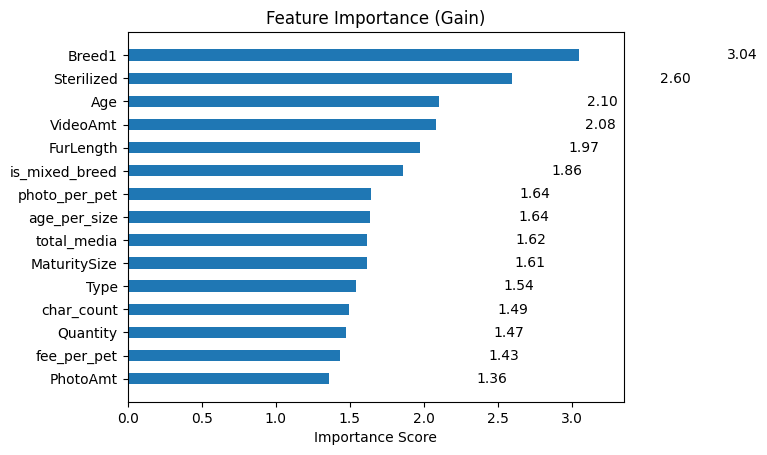

<Figure size 1200x600 with 0 Axes>

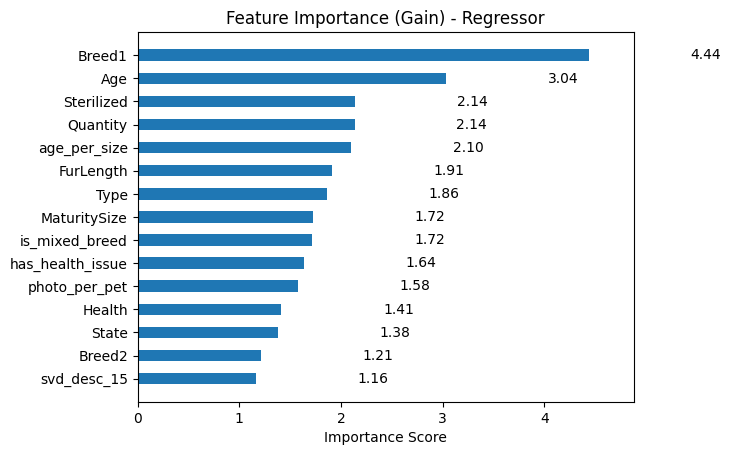

In [19]:
# Feature Importance: which factors benefit the prediction the most (extracted from XGBoost)
# ensure usage of original feature names not just np array indices
xgb_optuna.get_booster().feature_names = list(X_train.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_optuna, max_num_features=15, height=0.5, importance_type="gain", values_format = "{v:.2f}") # Weight ใช้อะไรมากที่สุดเป็นส่วนประกอบ tree, Gain อะไรแบ่งได้มากสุด
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()
# Also plot for the regressor model
xgb_optuna_reg.get_booster().feature_names = list(X_train.columns)

plt.figure(figsize=(12,6))
xgb.plot_importance(xgb_optuna_reg, max_num_features=15, height=0.5, importance_type="gain", values_format="{v:.2f}")
plt.title("Feature Importance (Gain) - Regressor")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.grid(False)
plt.show()

In [20]:
# Get feature importance from the classifier model
importance_dict = xgb_optuna.get_booster().get_score(importance_type='gain')

# Sort by importance (ascending to get the least important features)
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1])

# Get bottom 5 features
bottom_5 = sorted_importance[:5]

print("Bottom 5 least important features (by gain):")
for feature, importance in bottom_5:
    print(f"{feature}: {importance:.4f}")


print("Shit to drop:", [f for f, _ in bottom_5])

Bottom 5 least important features (by gain):
is_specific_color: 0.9167
Color1: 0.9815
Color3: 1.0425
avg_word_len: 1.1012
svd_desc_13: 1.1025
Shit to drop: ['is_specific_color', 'Color1', 'Color3', 'avg_word_len', 'svd_desc_13']
